<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 99101943
Name = 'Matin'
Last_Name = 'Alinejad'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

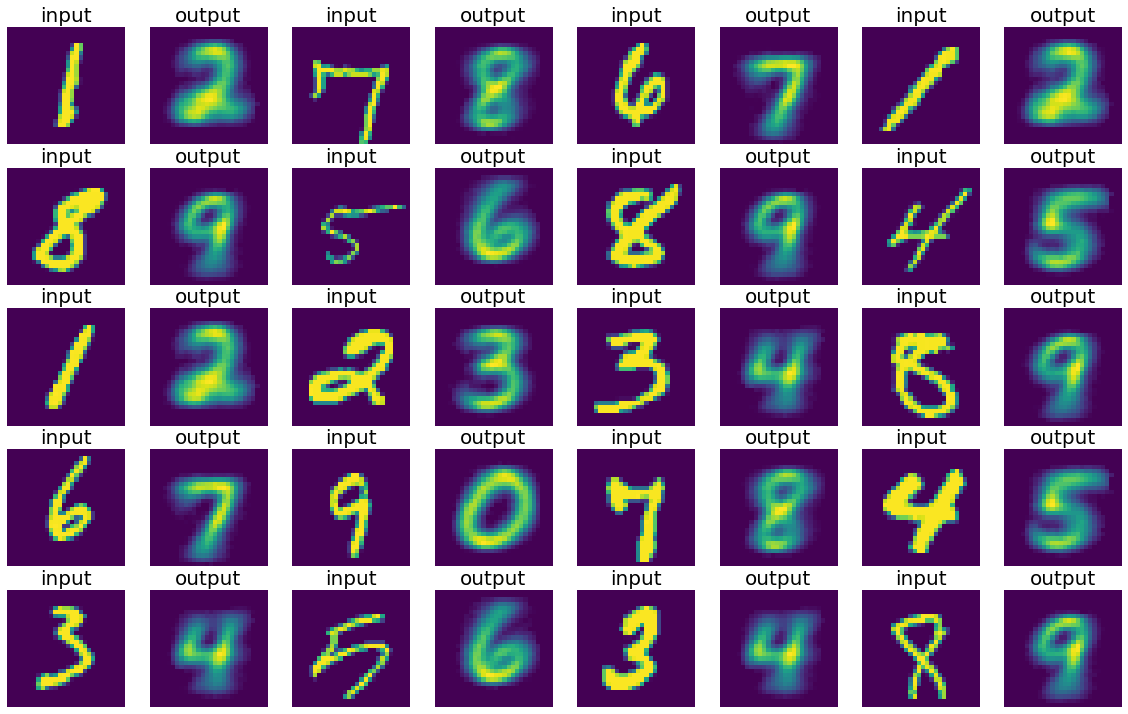

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
!pip install torch

  Using cached torch-2.3.0-cp38-cp38-win_amd64.whl (159.8 MB)


In [22]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size = 0.2, random_state = 17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size = 0.1, random_state = 17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [23]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # your code here
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # 16x14x14
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 32x7x7
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=7) # 64x1x1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7), # 32x7x7
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # 16x14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [24]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float().unsqueeze(1)  # Add channel dimension
        self.Y = torch.from_numpy(Y).float().unsqueeze(1)  # Add channel dimension
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [25]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size = 512,
    shuffle = True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size = 1024,
    shuffle = False
)

In [26]:
# place for your custom functions for training and evaluation of the autoencoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:

    # your code here
    model.train()
    epoch_loss = 0
    criterion = nn.MSELoss()
    
    for data in dataloader:
        inputs, targets, _ = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    return epoch_loss


def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:

    # your code here
    model.eval()
    epoch_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for data in dataloader:
            inputs, targets, _ = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    return epoch_loss

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [27]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device = device)
optimizer = torch.optim.Adam(ae.parameters(), lr = 0.001)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [28]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####

num_epochs = 20
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)
    
    # Check if we have a new best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = ae.state_dict()
    
    print(f'Epoch {epoch+1:02d}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Save the best model state
torch.save(best_model_state, 'best_autoencoder_model.pth')

Epoch 01, Train Loss: 0.0864, Validation Loss: 0.0682
Epoch 02, Train Loss: 0.0679, Validation Loss: 0.0675
Epoch 03, Train Loss: 0.0669, Validation Loss: 0.0659
Epoch 04, Train Loss: 0.0635, Validation Loss: 0.0613
Epoch 05, Train Loss: 0.0598, Validation Loss: 0.0589
Epoch 06, Train Loss: 0.0583, Validation Loss: 0.0579
Epoch 07, Train Loss: 0.0576, Validation Loss: 0.0573
Epoch 08, Train Loss: 0.0571, Validation Loss: 0.0570
Epoch 09, Train Loss: 0.0568, Validation Loss: 0.0567
Epoch 10, Train Loss: 0.0565, Validation Loss: 0.0564
Epoch 11, Train Loss: 0.0562, Validation Loss: 0.0562
Epoch 12, Train Loss: 0.0560, Validation Loss: 0.0560
Epoch 13, Train Loss: 0.0558, Validation Loss: 0.0559
Epoch 14, Train Loss: 0.0557, Validation Loss: 0.0557
Epoch 15, Train Loss: 0.0556, Validation Loss: 0.0556
Epoch 16, Train Loss: 0.0555, Validation Loss: 0.0556
Epoch 17, Train Loss: 0.0554, Validation Loss: 0.0555
Epoch 18, Train Loss: 0.0553, Validation Loss: 0.0554
Epoch 19, Train Loss: 0.0552

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [29]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####

# Load the best model state
best_model_state_path = 'best_autoencoder_model.pth'
ae.load_state_dict(torch.load(best_model_state_path, map_location=device))

# Verify if the model is loaded correctly
print("Best model state dictionary loaded successfully.")

Best model state dictionary loaded successfully.


## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

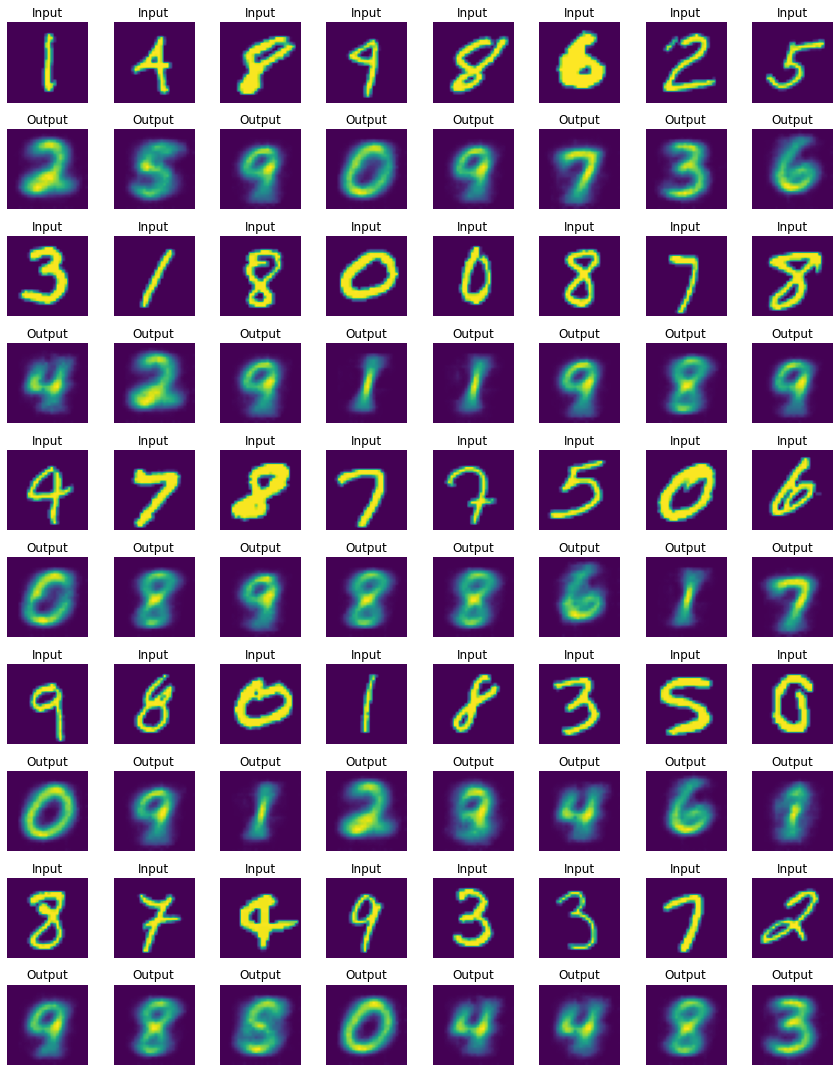

In [33]:
#### VISUALIZE YOUR MODEL ####

# Select 40 examples from the test set
num_examples = 40
indices = np.random.choice(len(X_test), num_examples, replace = False)
selected_inputs = torch.tensor(X_test[indices]).unsqueeze(1).to(device)
selected_outputs = torch.tensor(Y_test[indices]).unsqueeze(1).to(device)

# Generate the outputs from the model
ae.eval()
with torch.no_grad():
    reconstructed_outputs = ae(selected_inputs).cpu()

# Plot the input and output images
fig, axes = plt.subplots(10, 8, figsize = (12, 15))
for i in range(num_examples):
    ax_input = axes[i // 8 * 2, i % 8]
    ax_output = axes[i // 8 * 2 + 1, i % 8]
    
    ax_input.imshow(selected_inputs[i].cpu().numpy().squeeze(), cmap = 'viridis')
    ax_input.set_title("Input")
    ax_input.axis('off')
    
    ax_output.imshow(reconstructed_outputs[i].numpy().squeeze(), cmap = 'viridis')
    ax_output.set_title("Output")
    ax_output.axis('off')

plt.tight_layout()
plt.show()